In [1192]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import heavytools as hv
import pandas as pd
from matplotlib.patches import Rectangle

In [1193]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [1212]:
model_dirs = ["l1_logr", "pooled_nn", "pls", "pls_boosting"]
names = {"l2_logr": "Logistic Regression L2", "l2_svm": "Support VM L2", "l1_logr": "Logistic Regression L1", 
         "pooled_nn": "Pooled NN", "pls": "PLS", "pls_boosting": "PLS Boosting"}

fcms = {
    names[n]:np.load(open(f"out/functional_connectivity/{n}/fcms.npy", "rb")) for n in model_dirs
}

fcms

{'Logistic Regression L1': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.00232294,
          0.00943835, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.00232294, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.00943835, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.00081575,
          0.01034142, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.00081575, 0.        , ..., 0.        

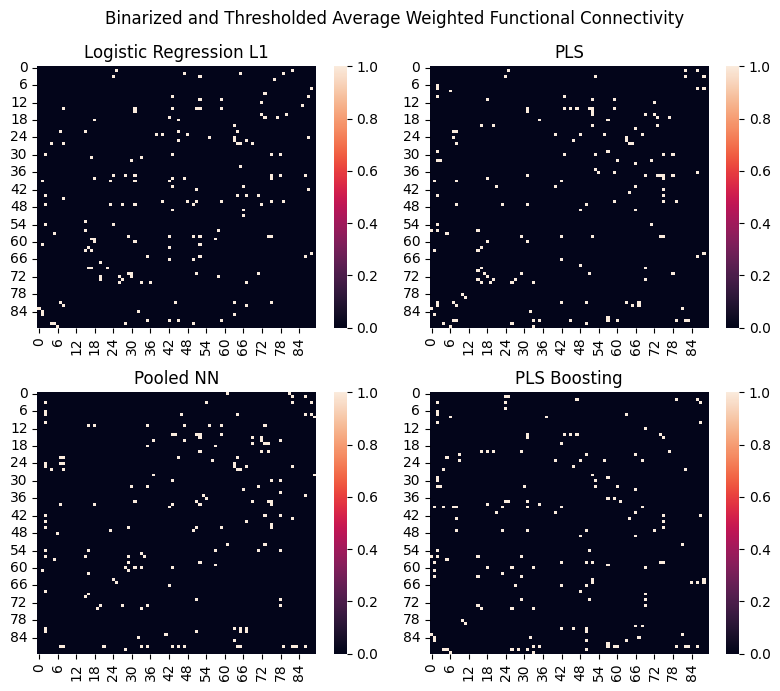

In [1213]:
gab_fcms = {m:hv.binarize(hv.threshold(np.mean(v, axis=0),0.02)) for m, v in fcms.items()}

fig, ax = plt.subplots(2, 2, figsize=(8, 7))
for i, (name, gab_fcm) in enumerate(gab_fcms.items()):
    sns.heatmap(np.rot90(gab_fcm), ax=ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)
    
fig.suptitle("Binarized and Thresholded Average Weighted Functional Connectivity")
fig.tight_layout()

In [1214]:
import networkx as nx

In [1215]:
def produce_graph(fcms):
    graph = nx.Graph()
    passed = set()
    for i in range(fcms.shape[0]):
        for j in range(fcms.shape[1]):
            if i == j:
                pass
        
            if fcms[i][j] > 0 and (j, i) not in passed:
                graph.add_edge(i, j)
                passed.add((i, j))
        
    return graph


In [1216]:
graphs = {m:produce_graph(v) for m, v in gab_fcms.items()}

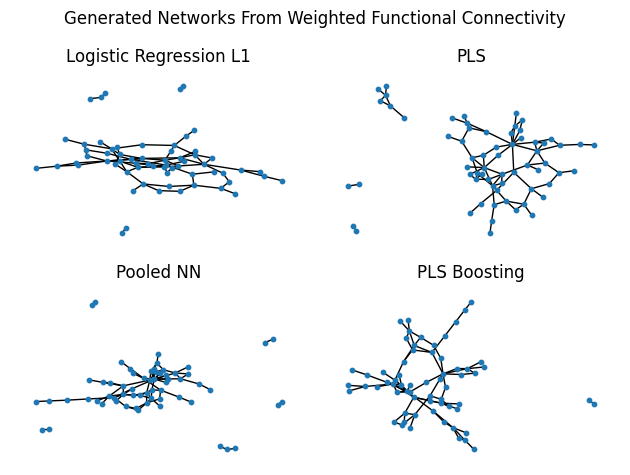

In [1217]:
fig, ax = plt.subplots(2, 2)

for i, (name, graph) in enumerate(graphs.items()):
    nx.draw(graph, node_size=10, ax=ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)

fig.suptitle("Generated Networks From Weighted Functional Connectivity")
fig.tight_layout()

In [1218]:
import colorsys

def girvan_newman(graph, iters=1):
    gen = nx.algorithms.community.girvan_newman(graph)
    for _ in range(iters):
        graph = next(gen)
    
    return graph

def get_n_colors(n):
    HSV_tuples = [(x*1.0/n, 0.5, 0.5) for x in range(n)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    return RGB_tuples

def get_color_map(gn, graph):
    RGB_tuples = get_n_colors(len(gn))
    
    cmap = {}
    for i, d in enumerate(gn):
        for s in d:
            cmap[s] = RGB_tuples[i]

    cmap_arr = []
    for n in graph.nodes:
        cmap_arr.append(cmap[n] if n in cmap else (0, 0, 0))
    
    return cmap_arr, cmap



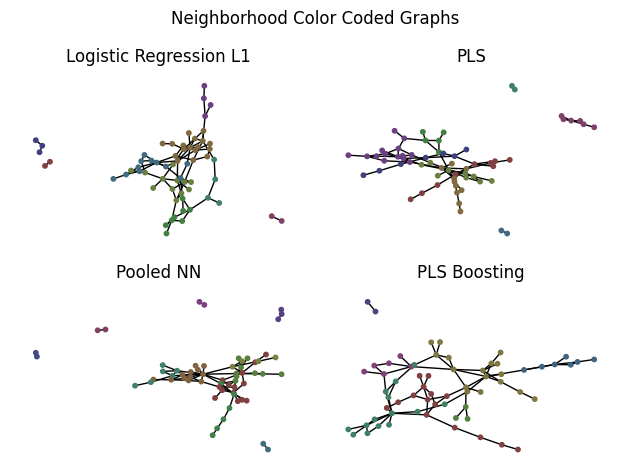

In [1219]:
fig, ax = plt.subplots(2, 2)
gns = {}
gn_cmaps = {}

for i, (name, graph) in enumerate(graphs.items()):
    gn = girvan_newman(graph, iters=5)
    gn_cmap, gn_cmap_g = get_color_map(gn, graph)
    
    gns[name] = gn
    gn_cmaps[name] = (gn_cmap, gn_cmap_g)

    nx.draw(graph, node_size=10, node_color=gn_cmap, ax=ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)

fig.suptitle("Neighborhood Color Coded Graphs")
fig.tight_layout()

In [1220]:
gns

{'Logistic Regression L1': ({0, 6},
  {1, 2, 5, 23, 24, 28, 31, 32, 35, 42, 50, 52, 59, 74, 75, 78, 86},
  {4, 7, 8, 44, 45, 55, 63, 64, 65, 67, 69, 71},
  {15, 17, 26, 30, 33, 36, 57, 58},
  {16, 20, 22, 27},
  {18, 29, 38, 40, 43, 47, 48, 51, 66, 79, 87},
  {25, 82, 88},
  {72, 73, 77, 80},
  {76, 85}),
 'Pooled NN': ({1, 18, 28, 29, 31, 43, 44, 51, 52, 59, 69, 72, 74, 75},
  {2, 4, 7, 8, 21, 45, 63, 64, 65, 67, 79, 83},
  {15, 19, 33, 34},
  {16, 20, 27, 30, 35, 55, 57, 71, 78},
  {37, 47, 61, 73, 81, 89},
  {46, 53, 54, 82, 86, 88},
  {5, 32},
  {6, 41},
  {23, 42, 50},
  {24, 25},
  {56, 66}),
 'PLS': ({0, 1, 4, 6, 15, 19, 26, 33, 81},
  {7, 8, 23, 42, 46, 50, 63, 64, 65, 67},
  {2, 3, 35, 45, 57, 60, 71, 79, 83},
  {24, 25, 82, 86, 88},
  {5, 32},
  {10, 11},
  {16, 20, 27, 69, 72, 73, 77},
  {17, 18, 29, 31, 43, 47, 51, 52, 53, 54, 59, 74, 75, 78},
  {21, 40, 48, 56, 66, 68}),
 'PLS Boosting': ({0, 6, 15, 16, 18, 20, 26, 29, 33, 35, 37, 51, 69, 77, 81},
  {1, 4, 7, 8, 23, 27, 28

In [1221]:
def get_sorted_indices(graph, gn, size=90):
    sorted_indices = []
    remaining_idxes = list(range(size))
    
    for i, cluster in enumerate(gn):
        for node in cluster:
            sorted_indices.append(node)
            remaining_idxes.remove(node)
            
    return sorted_indices + remaining_idxes

def paint_neighbors(gn, ax):
    c = 0
    for i, n in enumerate(gn):
        ax.add_patch(Rectangle((c, 89-c), len(n), -len(n),
                     edgecolor = get_n_colors(len(gn))[i],
                     fill=False,
                     lw=1))
        c += len(n)

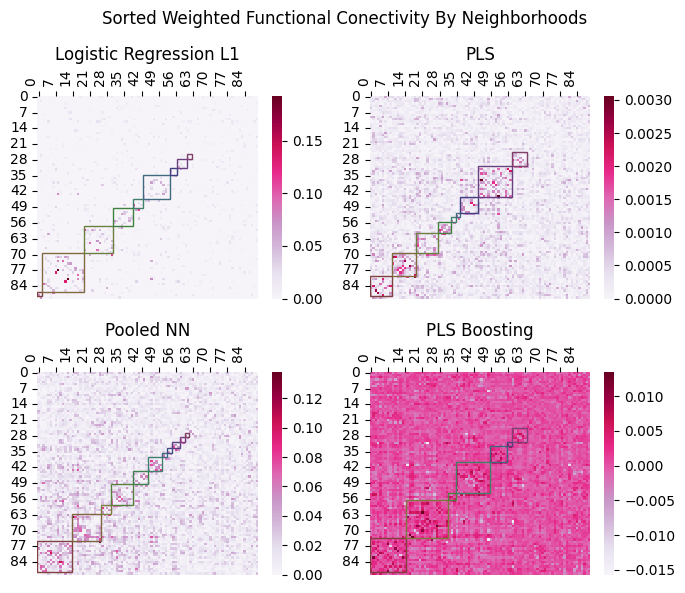

In [1222]:
fig, ax = plt.subplots(2, 2, figsize=(7, 6))

for i, (name, graph) in enumerate(graphs.items()):
    gn = gns[name]
    

    sorted_indices = get_sorted_indices(graph, gn, 64 if "double" in name else 90)
    sns.heatmap(np.rot90(np.mean(fcms[name], axis=0)[sorted_indices][:, sorted_indices]), ax=ax[i%2, i//2], cmap="PuRd")

    paint_neighbors(gn, ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)
    ax[i%2, i//2].xaxis.tick_top()
    ax[i%2, i//2].set_xticks(ax[i%2, i//2].get_xticks(), ax[i%2, i//2].get_xticklabels(), rotation=90, ha='right')



fig.suptitle("Sorted Weighted Functional Conectivity By Neighborhoods")
fig.tight_layout()

In [1223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import seaborn as sns
import utils as uu

In [1224]:
splits_df = pd.read_csv('data/mj_splits_training_testing.csv')
labels    = np.repeat(np.array(splits_df['label']), 2)
training  = np.repeat(np.array(splits_df['training']), 2)
names     = np.repeat(np.array(splits_df['subject']), 2)

In [1225]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [1226]:
x_train, x_test = inputs[training == 1], inputs[training == 0]
y_train, y_test = labels[training == 1], labels[training == 0]

In [1228]:
selected_features = []
l = 0
for g in np.array(gns["Logistic Regression L1"])[np.argsort([len(g) for g in gns["Logistic Regression L1"]], axis=0)[::-1]]:
    selected_features += g
    l += 1
selected_features = np.array(selected_features)#[:64]
selected_features, selected_features.shape,l

(array([32,  1,  2, 35,  5, 42, 75, 74, 78, 50, 52, 86, 23, 24, 59, 28, 31,
        64, 65, 67,  4, 69,  7,  8, 71, 44, 45, 55, 63, 66, 38, 40, 43, 47,
        79, 48, 18, 51, 87, 29, 33, 36, 58, 15, 17, 57, 26, 30, 72, 73, 80,
        77, 16, 27, 20, 22, 88, 25, 82, 76, 85,  0,  6]),
 (63,),
 9)

In [1229]:
x_train_select = np.array([hv.convert_triangle_to_mat(h) for h in x_train])[:, selected_features, :][:, :, selected_features]
x_test_select = np.array([hv.convert_triangle_to_mat(h) for h in x_test])[:, selected_features, :][:, :, selected_features]

x_train_select = np.array([uu.symm_mat_to_ut_vec(h) for h in x_train_select])
x_test_select = np.array([uu.symm_mat_to_ut_vec(h) for h in x_test_select])


In [1189]:
from sklearn.calibration import CalibratedClassifierCV

#class_weight = {0: 0.4, 1: 0.6}
# best hyperparameters: l1_svm: 0.02, l2_svm: 0.2, l1_logr: 0.01, l2_logr: 0.1
class_weight=None
model_l1_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l1_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)

models = {"Logistic Regression L1":model_l1_logr, "Logistic Regression L2": model_l2_logr, 
          "Support VM L1":model_l1_svm, "Support VM L2": model_l2_svm}

 Training model Logistic Regression L2, fold 6/10

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/_plotting.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


 Training model Support VM L2, fold 9/10fold 9/10

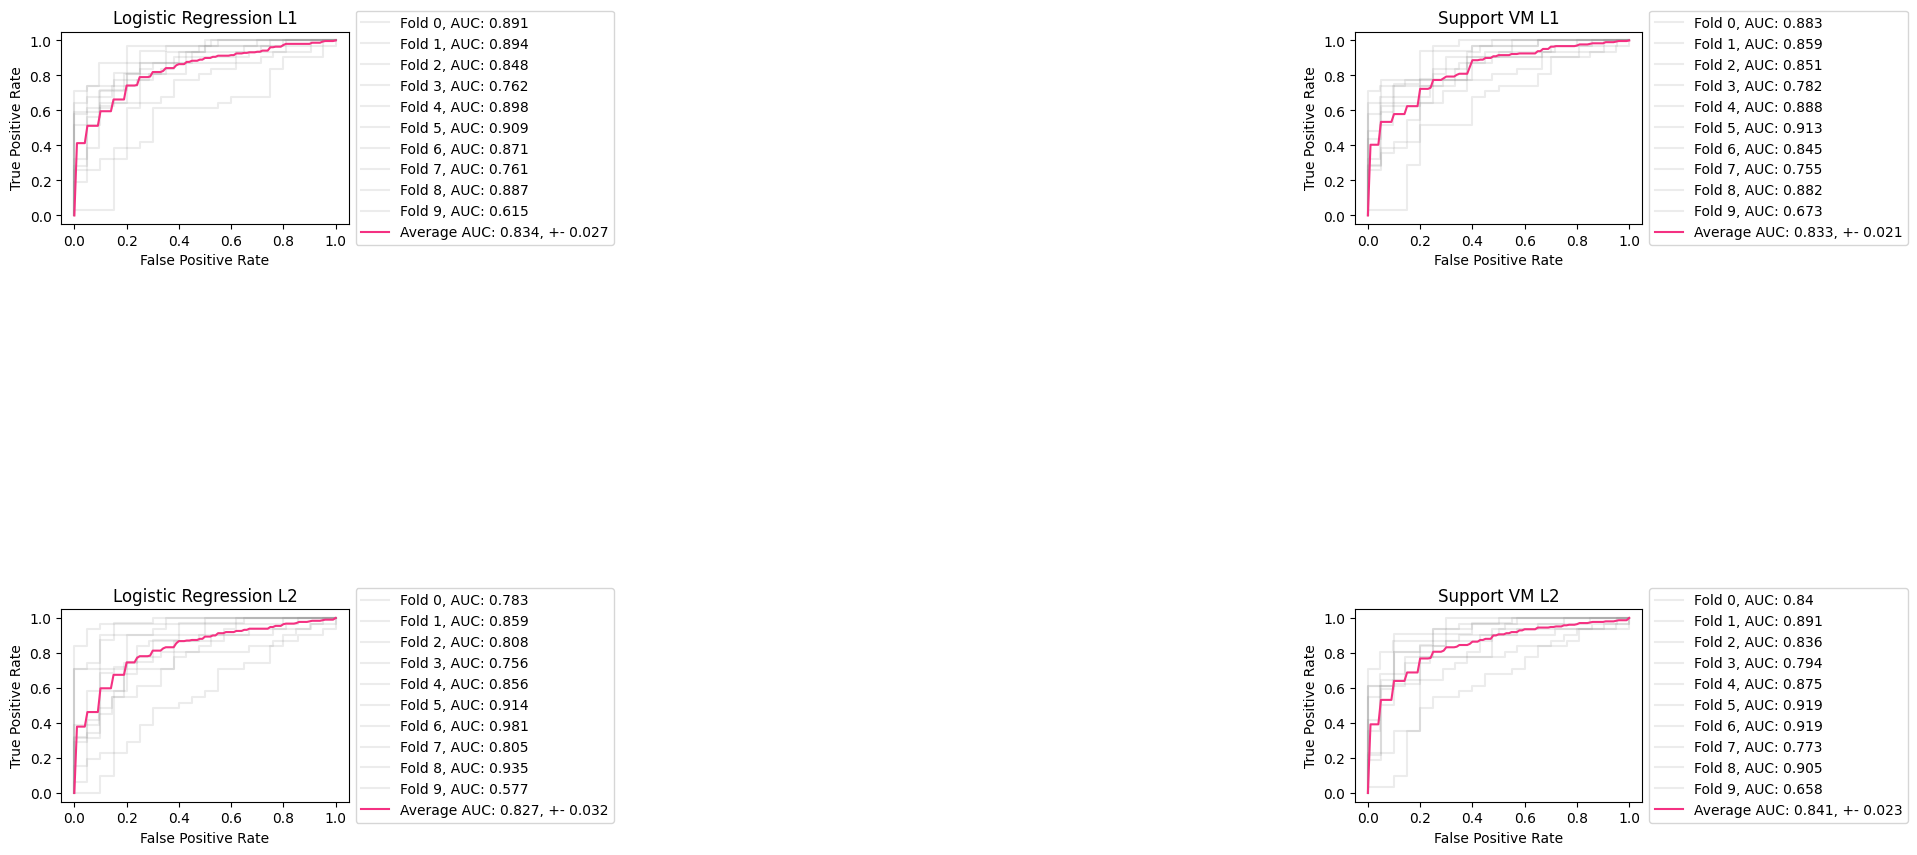

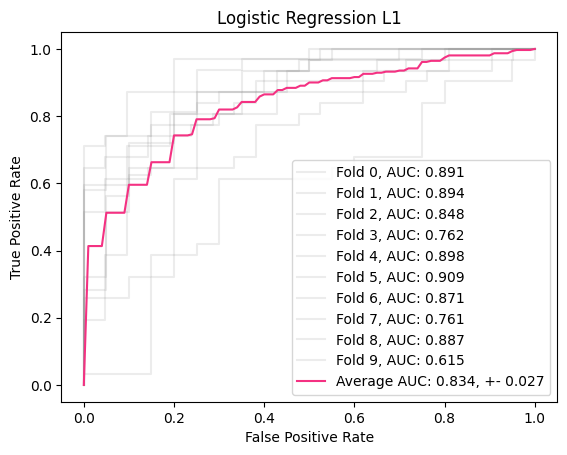

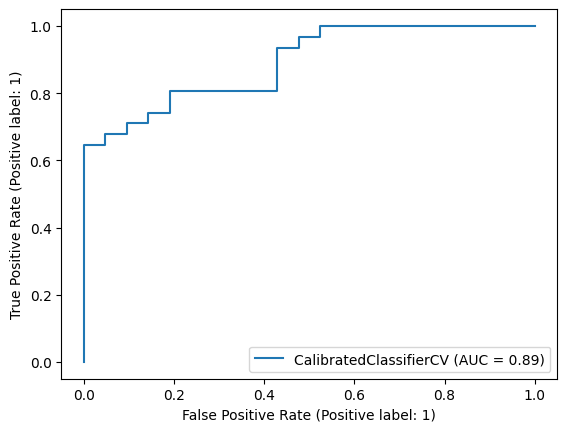

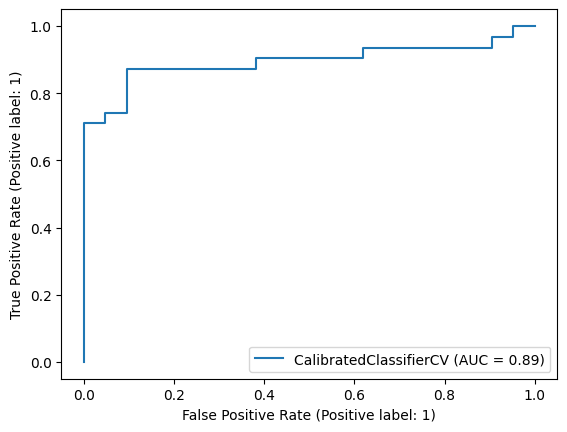

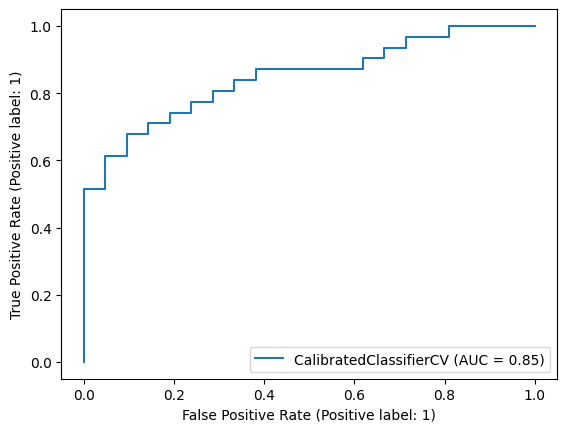

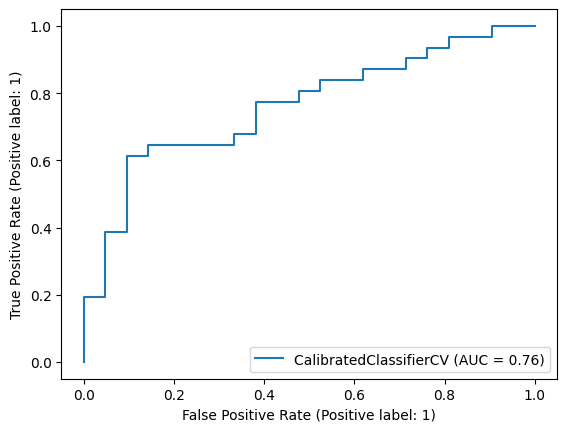

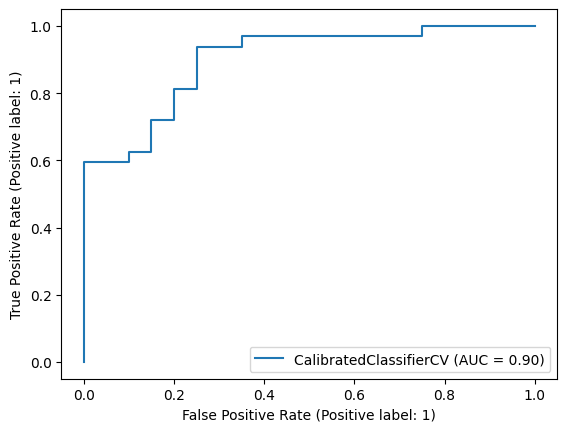

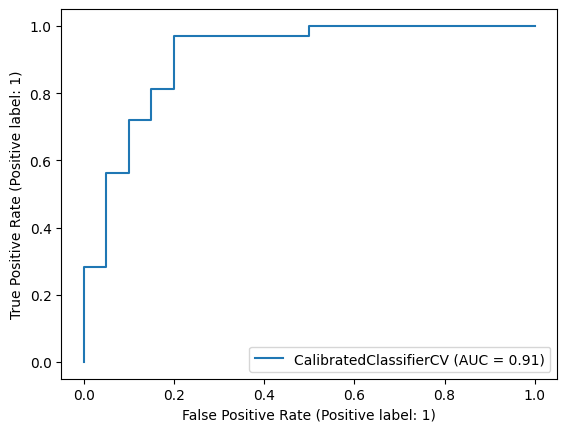

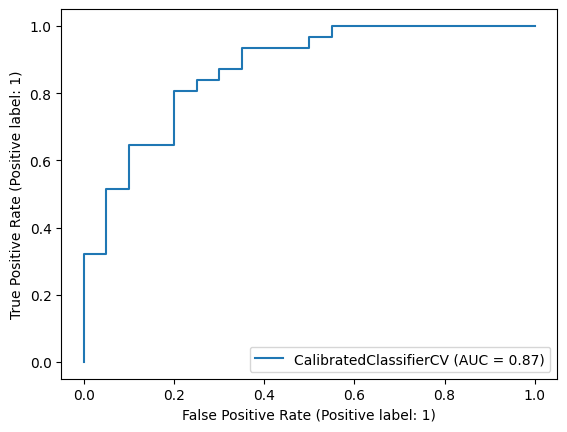

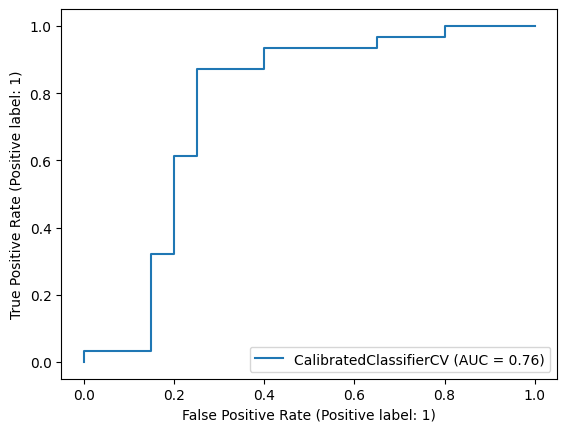

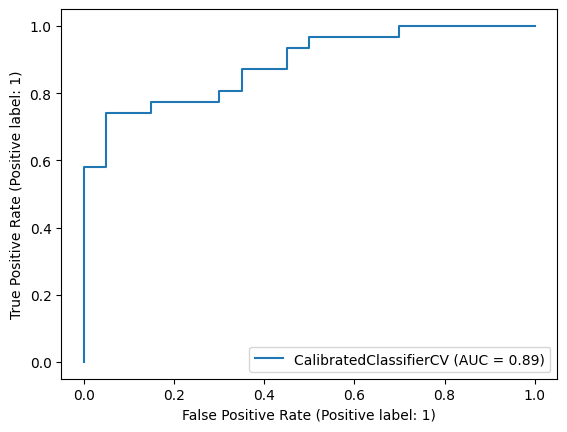

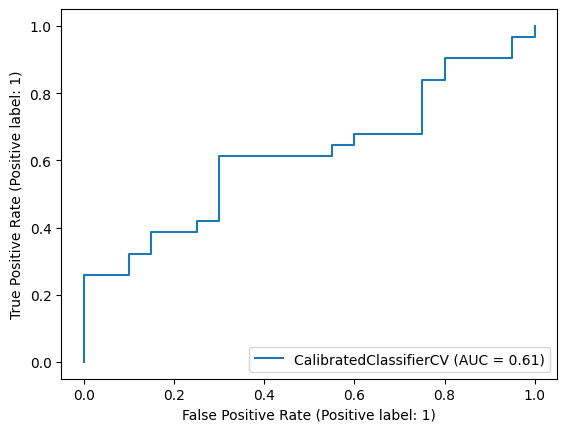

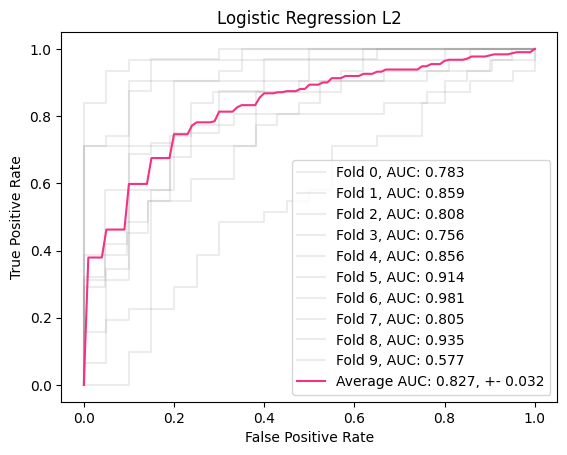

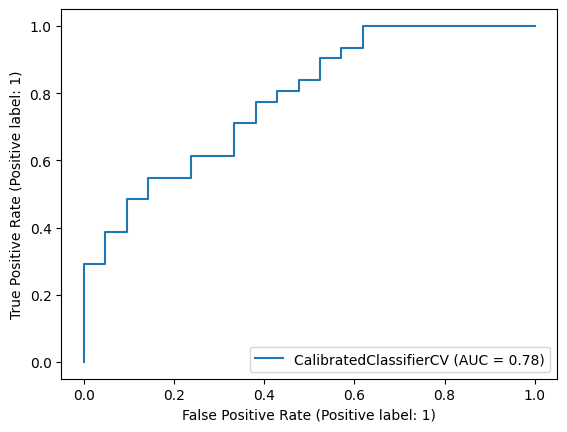

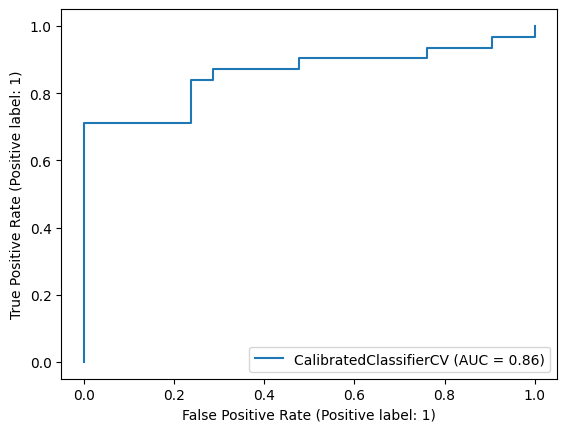

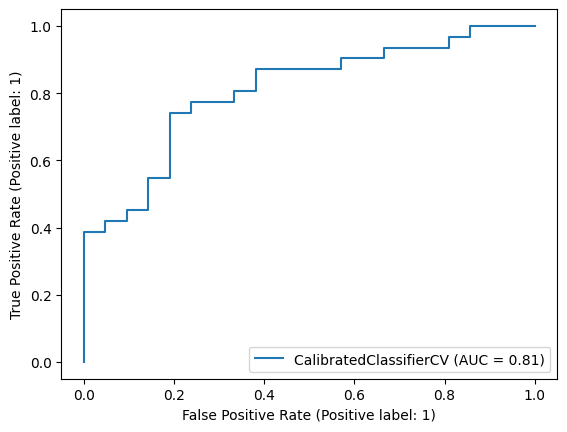

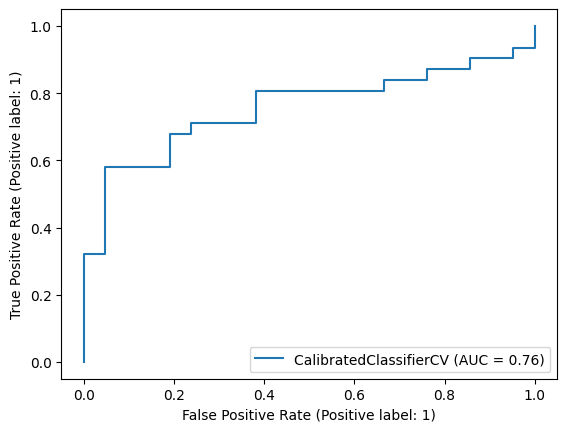

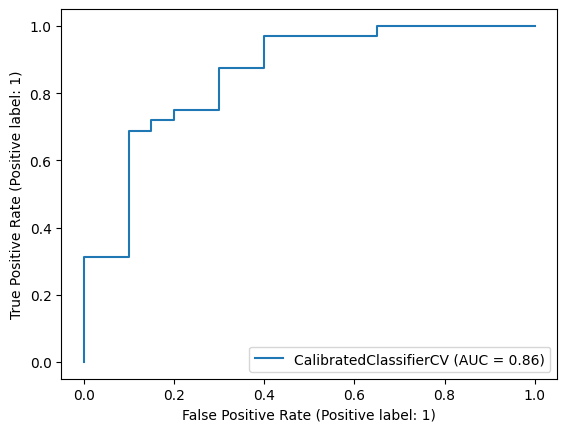

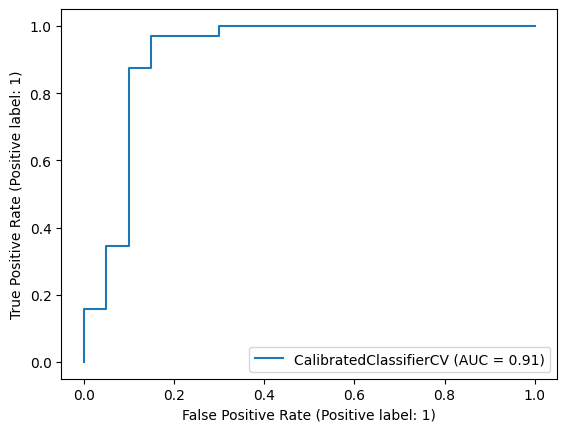

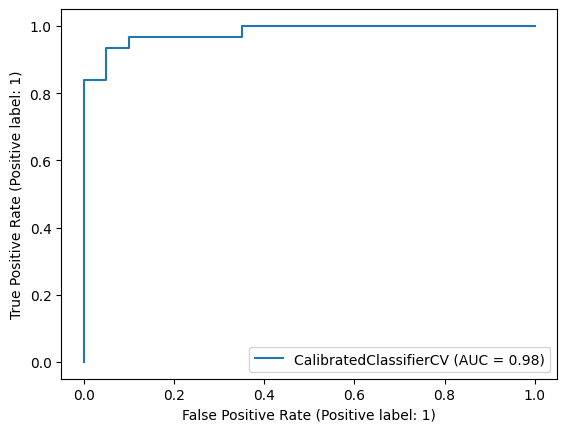

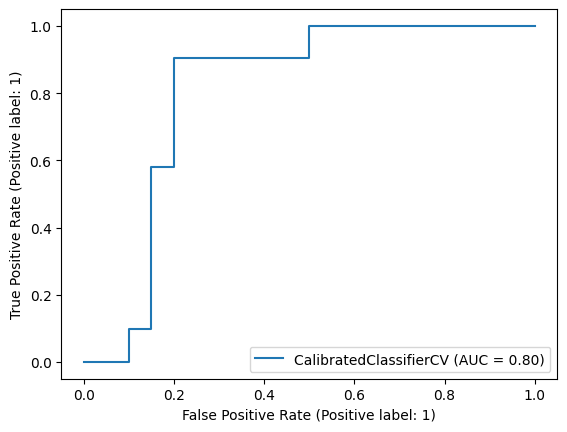

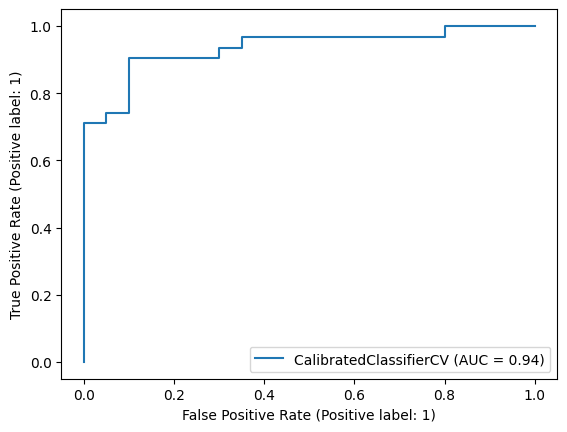

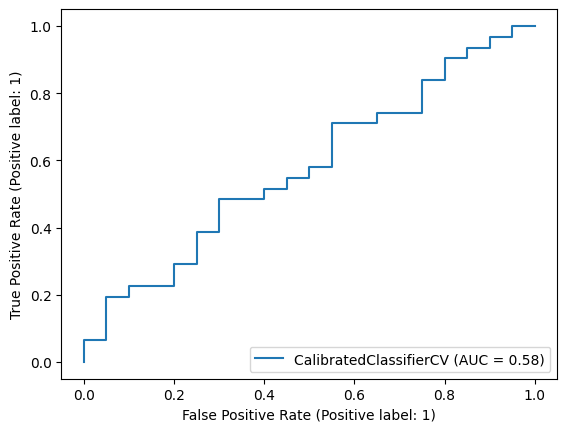

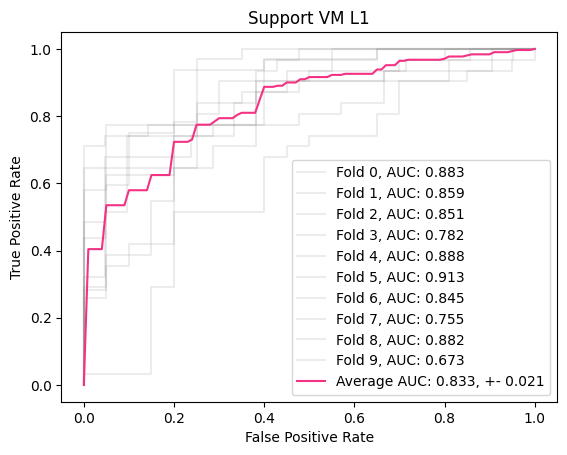

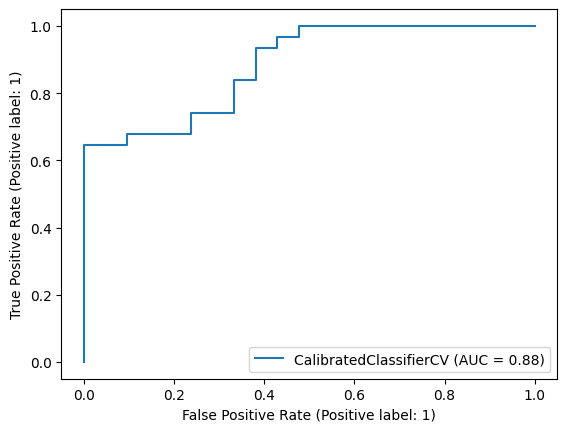

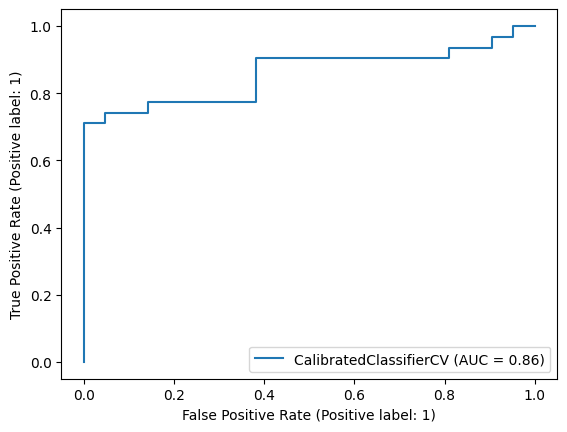

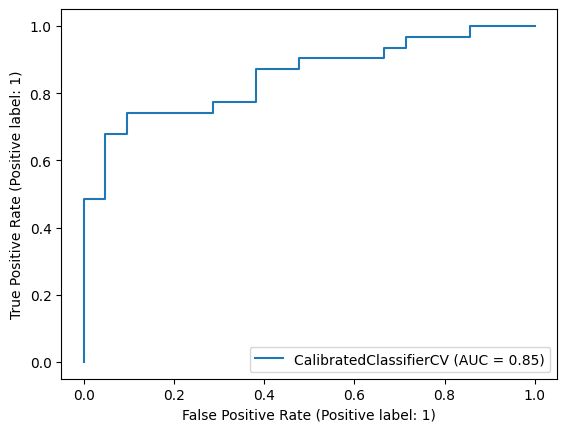

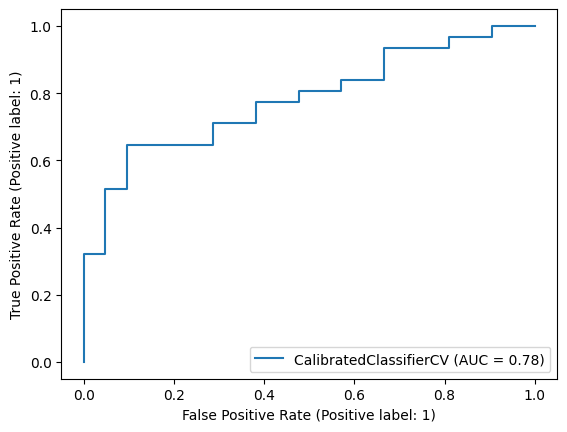

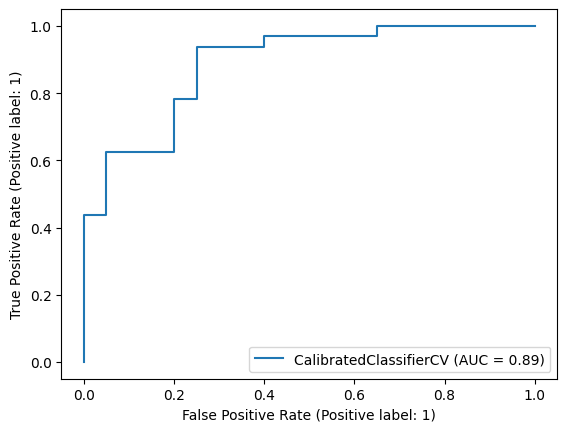

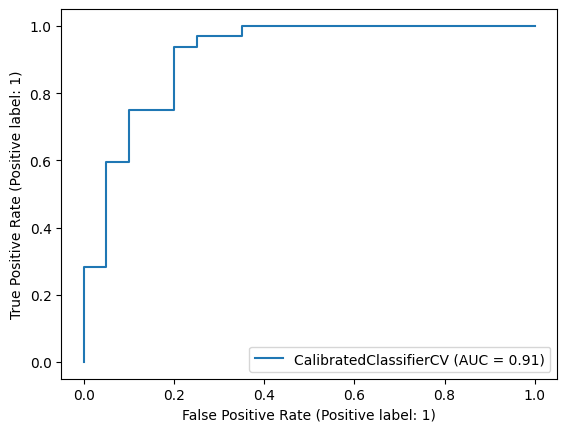

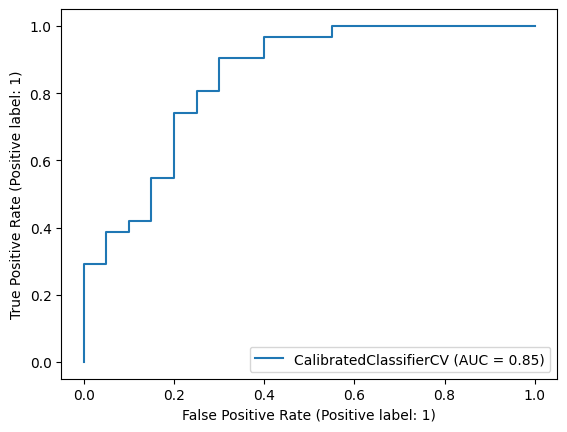

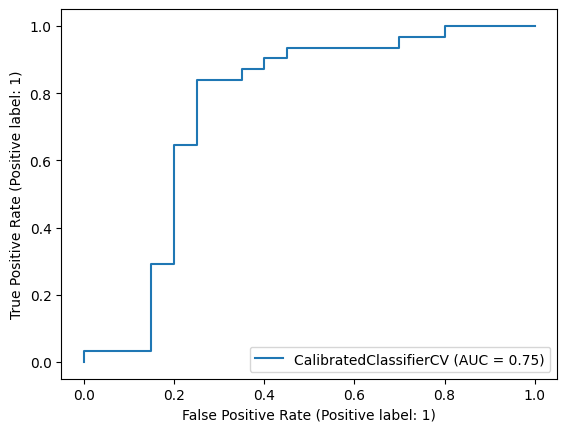

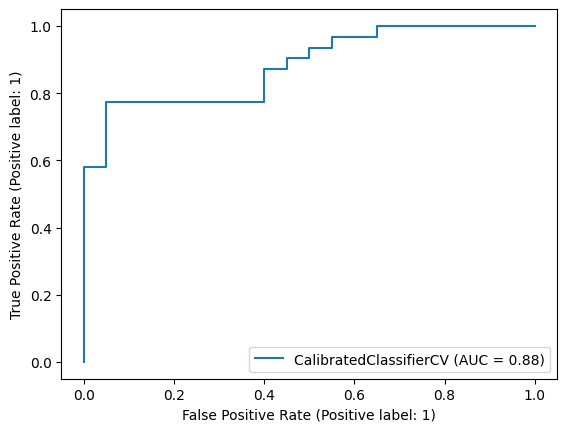

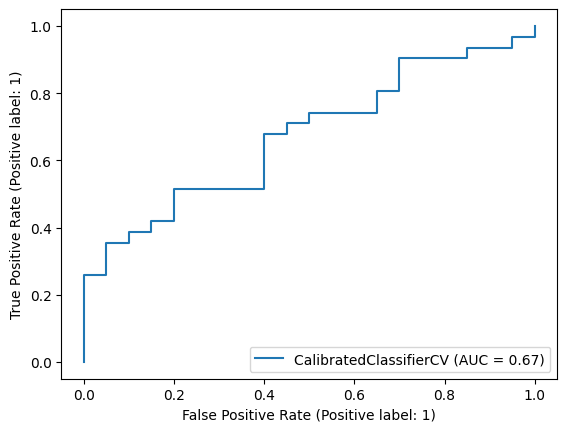

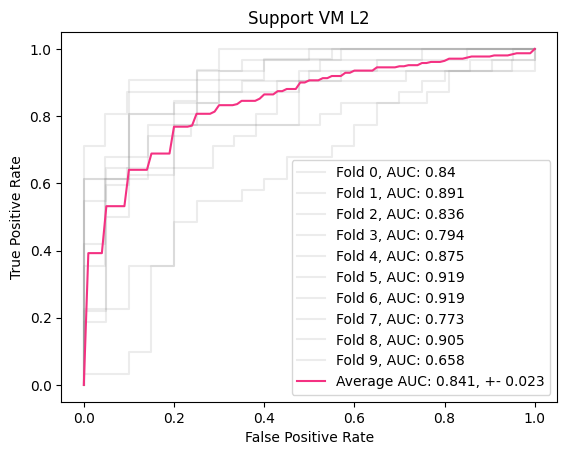

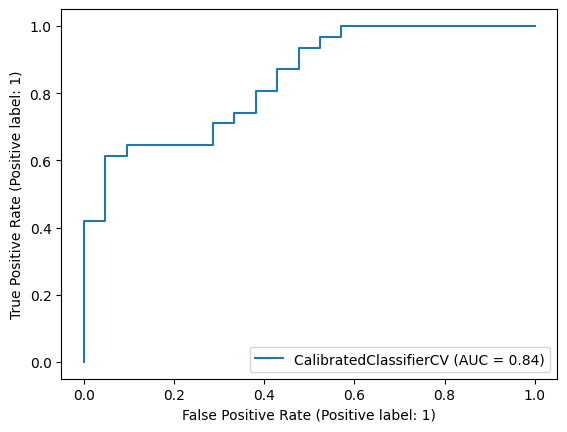

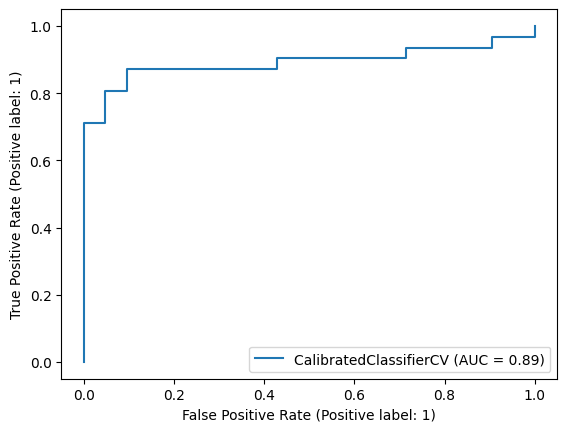

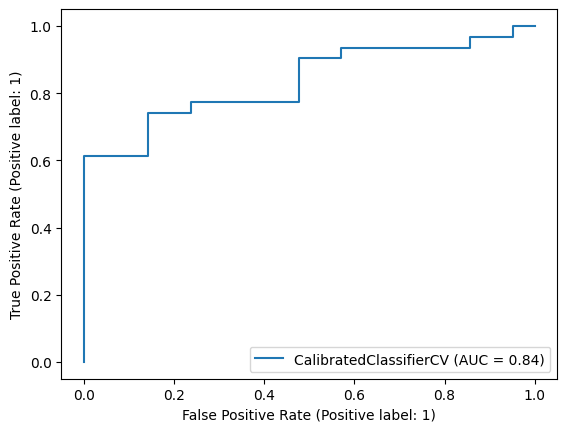

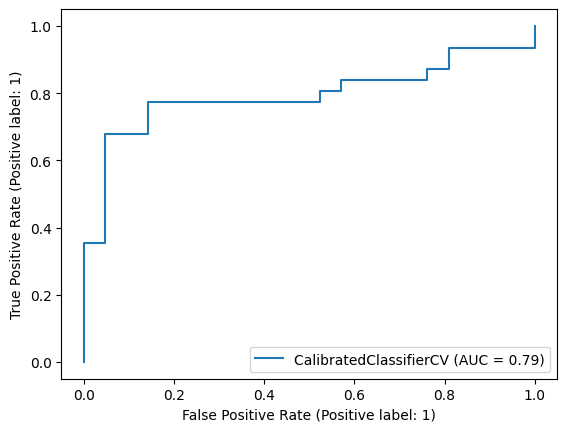

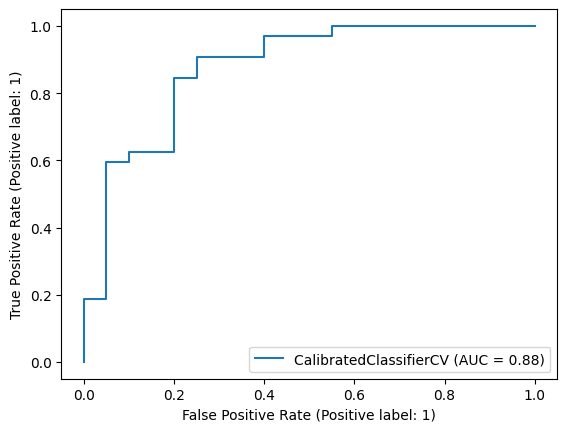

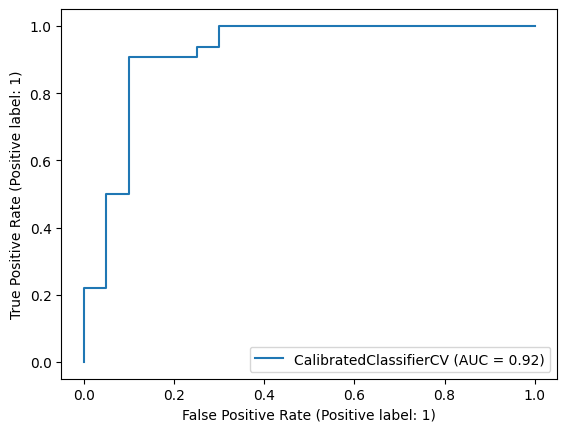

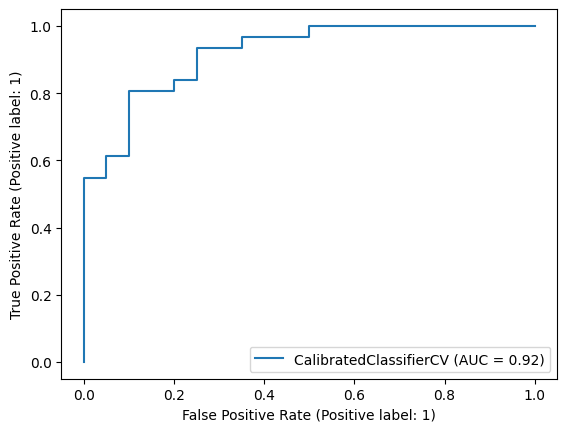

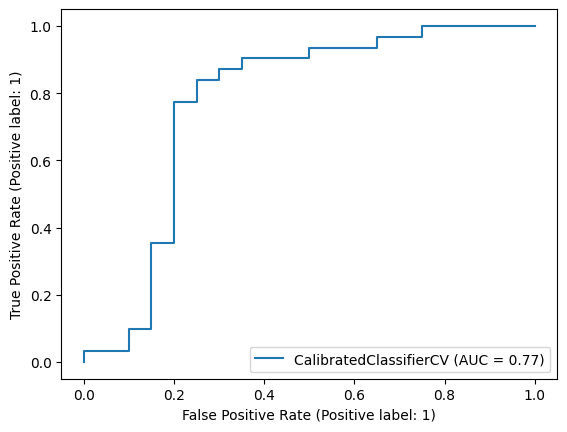

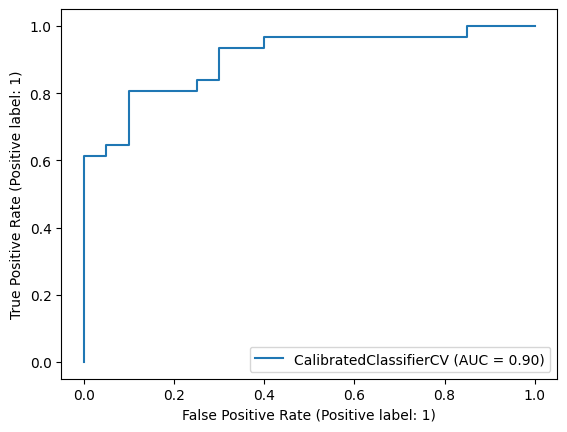

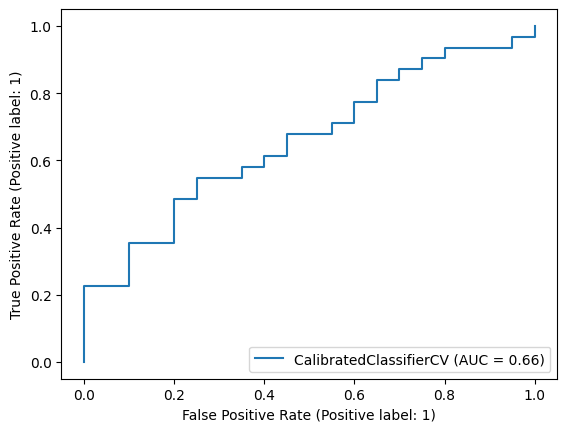

In [1190]:
metrics = {
    "accuracy": lambda yh, pyh, y: sklearn.metrics.accuracy_score(y, yh), 
    "auc": lambda yh, pyh, y: sklearn.metrics.roc_auc_score(y, pyh)         
}

folds = 10
tot_fig, tot_ax = plt.subplots(2, 2, figsize=(17, 10))

train_metrics = {}
for ax_idx, (model_name, model) in enumerate(models.items()):
    skf = uu.StratifiedKFold(n_splits=folds)

    fig, ax = plt.subplots()

    train_metrics[model_name] = {}

    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    for j, (train_index, test_index) in enumerate(skf.split(x_train_select, y_train)):
        train_metrics[model_name][j] = {}
        model_cln = CalibratedClassifierCV(uu.clone(model)) if "svm" in model_name or "forest" else uu.clone(model)

        fold_x_train, fold_x_test = x_train_select[train_index], x_train_select[test_index]
        fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

        model_cln.fit(fold_x_train, fold_y_train)
        test_pred = model_cln.predict(fold_x_test)
        test_pred_probs = model_cln.predict_proba(fold_x_test)[:, 1]
        
        for metric_name, metric_fn in metrics.items():
            train_metrics[model_name][j][metric_name] = metric_fn(test_pred, test_pred_probs, fold_y_test)

        viz_data = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test)
        fpr = viz_data.fpr
        tpr = viz_data.tpr

        train_metrics[model_name][j]["fpr_tpr"] = (fpr, tpr)
        train_metrics[model_name][j]["auc"] = viz_data.roc_auc

        roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Fold {j}, AUC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        tot_ax[ax_idx%2, ax_idx//2].plot(fpr, tpr, alpha=0.15, color="gray", label=f"Fold {j}, AUROC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        train_metrics[model_name][j]["roc_plot"] = roc

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

        print("\r", f"Training model {model_name}, fold {j}/{folds}", end="")

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    aucs = [m['auc'] for _, m in train_metrics[model_name].items()]
    mean_auc = np.mean(aucs)
    sd_auc = np.std(aucs)

    ci = 0.95 * sd_auc / np.sqrt(len(aucs))

    ax.plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)  
    tot_ax[ax_idx%2, ax_idx//2].plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    box = tot_ax[ax_idx%2, ax_idx//2].get_position()
    tot_ax[ax_idx%2, ax_idx//2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    tot_ax[ax_idx%2, ax_idx//2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))


    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)
    tot_ax[ax_idx%2, ax_idx//2].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)

    train_metrics[model_name]["roc_curve"] = fig

tot_fig.subplots_adjust(left=0.07, right=1, wspace=3.5, hspace=2)

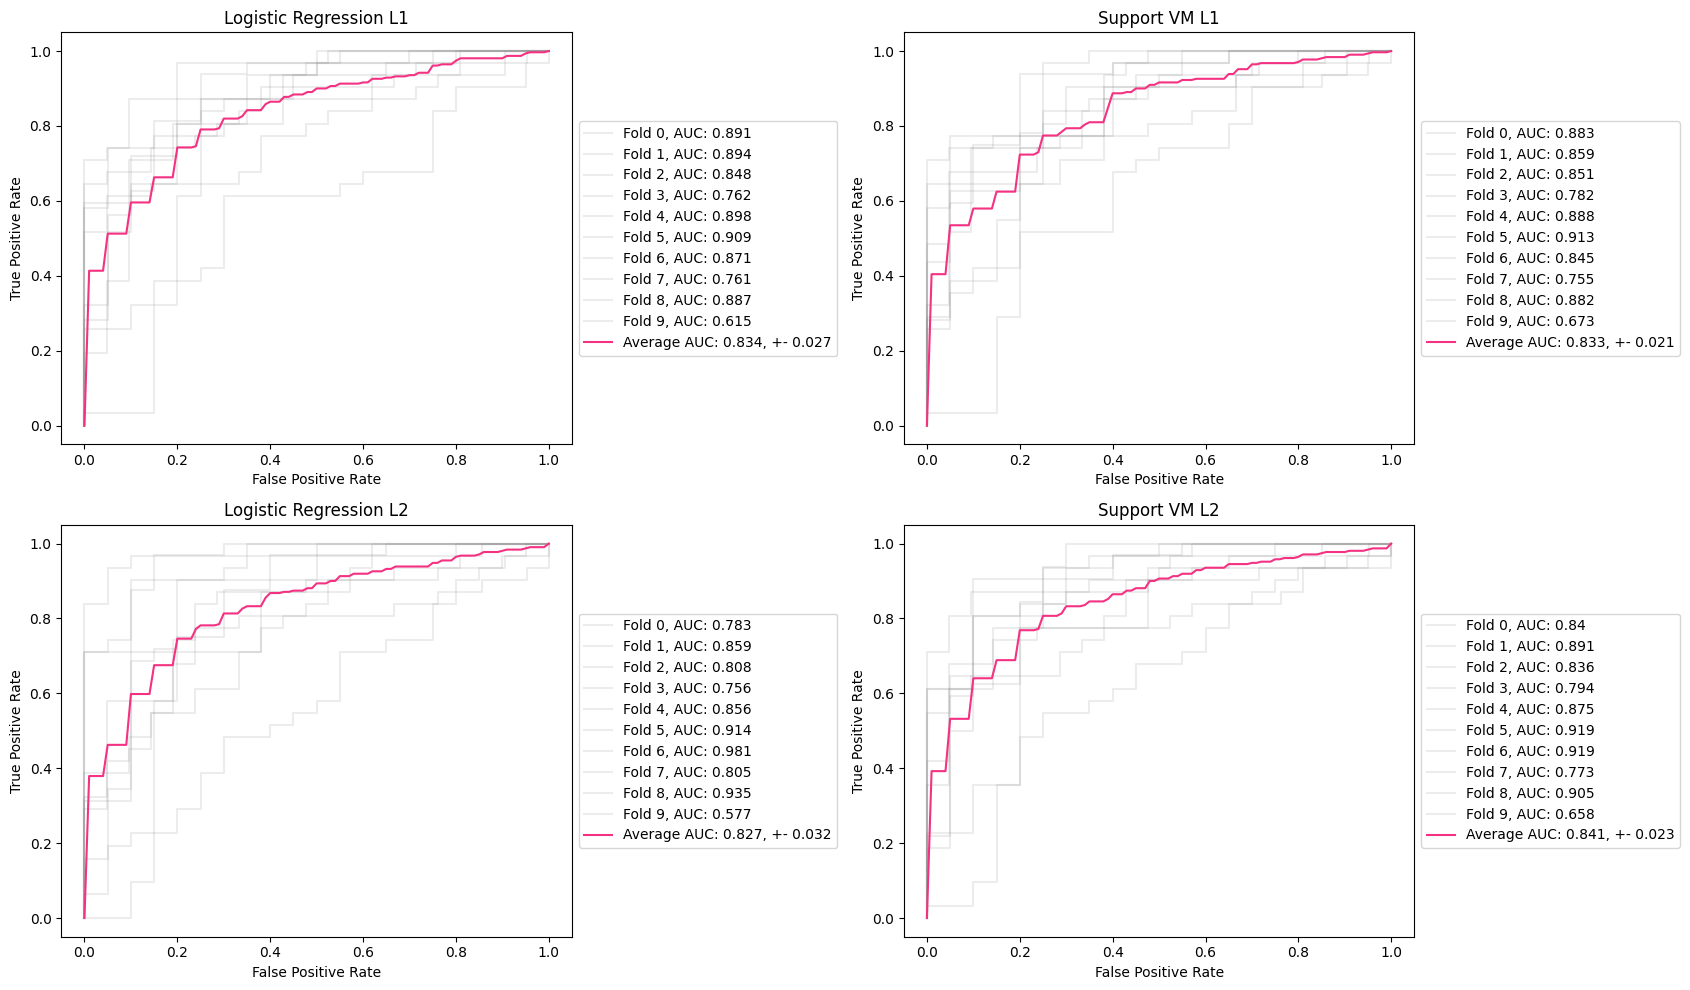

In [1191]:
tot_fig.tight_layout()
tot_fig

In [1230]:
class_weight = None

model_l1_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l1_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)

models = {"l1_logr":model_l1_logr, "l2_logr": model_l2_logr, 
          "l1_svm":model_l1_svm, "l2_svm": model_l2_svm}

for model_name, model in models.items():
    print("\r", f"fitting {model_name}", end="")
    model.fit(x_train_select, y_train)
print("")
print("finished")

 fitting l2_svmr
finished


In [ ]:
metrics = {
    "accuracy": lambda model, yh, pyh, y: sklearn.metrics.accuracy_score(y, yh), 
    "auc": lambda model, yh, pyh, y: sklearn.metrics.roc_auc_score(y, pyh)         
}

def evaluate(model, model_type, metrics=metrics):
    x_pred = model.predict(x_test_select)
    x_proba = model.predict_proba(x_test_select)[:, 1] if model_type != "svm" else model.decision_function(x_test_select)
    return {k: v(model, x_pred, x_proba, y_test) for k, v in metrics.items()}

def pprint_metrics(metrics, name):
    print(f"{name} model test accuracy: {metrics['accuracy']}, test auc: {metrics['auc']}")

metrics_l1_logr = evaluate(model_l1_logr, "logr")
metrics_l2_logr = evaluate(model_l2_logr, "logr")
metrics_l1_svm = evaluate(model_l1_svm, "svm")
metrics_l2_svm = evaluate(model_l2_svm, "svm")

pprint_metrics(metrics_l1_logr, "l1 logistic regression")
pprint_metrics(metrics_l2_logr, "l2 logistic regression")
pprint_metrics(metrics_l1_svm, "l1 support vector mach")
pprint_metrics(metrics_l2_svm, "l2 support vector mach")
print(model_l1_logr.score(x_train_select, y_train))

In [1231]:
# L1 LOGR

l1 logistic regression model test accuracy: 0.7615384615384615, test auc: 0.8545364891518739
l2 logistic regression model test accuracy: 0.8076923076923077, test auc: 0.8796844181459567
l1 support vector mach model test accuracy: 0.7846153846153846, test auc: 0.8557692307692307
l2 support vector mach model test accuracy: 0.8307692307692308, test auc: 0.8966962524654832
1.0


In [1116]:
# L2 SVM

l1 logistic regression model test accuracy: 0.7692307692307693, test auc: 0.8584812623274162
l2 logistic regression model test accuracy: 0.8, test auc: 0.8895463510848126
l1 support vector mach model test accuracy: 0.8, test auc: 0.8920118343195266
l2 support vector mach model test accuracy: 0.8538461538461538, test auc: 0.907051282051282
1.0


In [628]:
# results from PLS boosting model

l1 logistic regression model test accuracy: 0.8, test auc: 0.8918885601577909
l2 logistic regression model test accuracy: 0.8076923076923077, test auc: 0.9134615384615384
l1 support vector mach model test accuracy: 0.8153846153846154, test auc: 0.9080374753451677
l2 support vector mach model test accuracy: 0.8307692307692308, test auc: 0.9151873767258383


In [455]:
#results from PLS model

l1 logistic regression model test accuracy: 0.8, test auc: 0.8920118343195266
l2 logistic regression model test accuracy: 0.7769230769230769, test auc: 0.9006410256410257
l1 support vector mach model test accuracy: 0.7923076923076923, test auc: 0.9011341222879684
l2 support vector mach model test accuracy: 0.823076923076923, test auc: 0.905078895463511


In [464]:
# results from pooled nn model

l1 logistic regression model test accuracy: 0.823076923076923, test auc: 0.8794378698224852
l2 logistic regression model test accuracy: 0.7923076923076923, test auc: 0.8922583826429981
l1 support vector mach model test accuracy: 0.8307692307692308, test auc: 0.8929980276134123
l2 support vector mach model test accuracy: 0.823076923076923, test auc: 0.8954635108481263


In [474]:
# results from nn model

l1 logistic regression model test accuracy: 0.7769230769230769, test auc: 0.8862179487179487
l2 logistic regression model test accuracy: 0.823076923076923, test auc: 0.9013806706114398
l1 support vector mach model test accuracy: 0.8076923076923077, test auc: 0.8925049309664694
l2 support vector mach model test accuracy: 0.8076923076923077, test auc: 0.8925049309664694


In [484]:
# results from linear l1 svm

l1 logistic regression model test accuracy: 0.7615384615384615, test auc: 0.854043392504931
l2 logistic regression model test accuracy: 0.8, test auc: 0.8838757396449703
l1 support vector mach model test accuracy: 0.7307692307692307, test auc: 0.8431952662721894
l2 support vector mach model test accuracy: 0.8, test auc: 0.9013806706114398


In [631]:
import sklearn.cross_decomposition

([<matplotlib.axis.XTick at 0x7f9e1aaa9130>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29')])

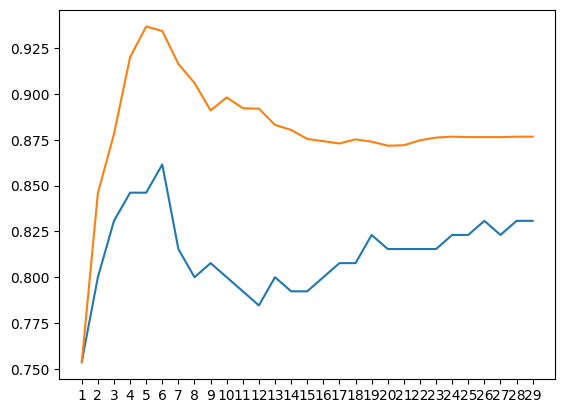

In [656]:
accs = []
aucs = []
components = []
for i in range(1, 30):
    pls5 = sklearn.cross_decomposition.PLSRegression(i)
    pls5.fit(x_train_select, y_train)
    preds = pls5.predict(x_test_select)[:, 0]
    acc = np.mean(np.round(preds) == y_test)
    auc = sklearn.metrics.roc_auc_score(y_test, preds)
    components.append(i)
    accs.append(acc)
    aucs.append(auc)

plt.plot(components, accs)
plt.plot(components, aucs)
plt.xticks(components)

In [790]:
pls5 = sklearn.cross_decomposition.PLSRegression(6)
pls5.fit(x_train_select, y_train)
preds = pls5.predict(x_test_select)[:, 0]
acc = np.mean(np.round(preds) == y_test)
auc = sklearn.metrics.roc_auc_score(y_test, preds)

acc, auc

(0.8692307692307693, 0.9287475345167653)

In [663]:
pls5 = sklearn.cross_decomposition.PLSRegression(6)
pls5.fit(x_train_select, y_train)
preds = pls5.predict(x_test_select)[:, 0]
acc = np.mean(np.round(preds) == y_test)
auc = sklearn.metrics.roc_auc_score(y_test, preds)

acc, auc

(0.8615384615384616, 0.9344181459566075)

In [664]:
import xgboost as xgb

In [791]:
x_train_sel_pls = pls5.transform(x_train_select)
x_test_sel_pls = pls5.transform(x_test_select)

In [792]:
xgbmodel = xgb.XGBClassifier(n_estimators=100, booster="gblinear", reg_lambda=3, reg_alpha=0, scale_pos_weight=0.4/0.6, random_state=1)
xgbmodel.fit(x_train_sel_pls, y_train)

xgbmodel.score(x_test_sel_pls, y_test), sklearn.metrics.roc_auc_score(y_test, xgbmodel.predict_proba(x_test_sel_pls)[:, 1])

(0.8615384615384616, 0.9129684418145957)

In [680]:
xgbmodel = xgb.XGBClassifier(n_estimators=100, booster="gblinear", reg_lambda=3, reg_alpha=0, scale_pos_weight=0.4/0.6, random_state=1)
xgbmodel.fit(x_train_sel_pls, y_train)

xgbmodel.score(x_test_sel_pls, y_test), sklearn.metrics.roc_auc_score(y_test, xgbmodel.predict_proba(x_test_sel_pls)[:, 1])

(0.8692307692307693, 0.930473372781065)

In [692]:
import utils as uu

In [701]:
bcs = [np.abs(uu.ut_vec_to_symm_mat(x_test_select[i])) for i in range(x_test_select.shape[0])]
fcms = [b * uu.ut_vec_to_symm_mat(np.abs(pls5.x_weights_.dot(xgbmodel.coef_))) for b in bcs]

In [704]:
fcms[0].shape

(64, 64)

In [706]:
import os
os.makedirs("out/functional_connectivity/pls_double_boost", exist_ok=True)
with open("out/functional_connectivity/pls_double_boost/fcms.npy", "wb+") as f:
    np.save(f, fcms)

In [1240]:
centrals = np.load("mean_centrals_pls_boosting.npy")
centrals.shape[0]

90

In [1235]:
gns["PLS Boosting"]

({0, 6, 15, 16, 18, 20, 26, 29, 33, 35, 37, 51, 69, 77, 81},
 {1, 4, 7, 8, 23, 27, 28, 31, 42, 43, 45, 46, 50, 64, 72, 74, 75},
 {5, 32, 67},
 {2, 3, 30, 47, 53, 57, 59, 60, 63, 79, 82, 83, 86, 87},
 {9, 21, 40, 48, 56, 66, 68},
 {10, 11},
 {24, 25, 52, 61, 84, 88})

In [1243]:
roi_labels = pd.read_table('data/stanford_coord_mapping_nonetwork.tsv')
roi_labels

,Unnamed: 0,stanford_name,coordinates,description,parcel_ind
0,0,ant_sal_1,"[-32, 48, 20]",L prefrontal cortex,0
1,1,ant_sal_2,"[-42, 14, -4]",L anterior insula,1
2,2,ant_sal_3,"[0, 18, 44]",bilateral ACC,2
3,3,ant_sal_4,"[28, 45, 27]",R frontal gyrus,3
4,4,ant_sal_5,"[45, 13, 0]",R anterior insula,4
...,...,...,...,...,...
85,85,visiospatial_7,"[46, 10, 28]",R precentral/fronto-opercular region,85
86,86,visiospatial_8,"[50, -57, -10]",R inferior temporal cortex,86
87,87,visiospatial_9,"[-27, -72, -51]",L cerebellum,87
88,88,visiospatial_10,"[23, -72, -50]",R cerebellum,88


In [1245]:
descs = np.array(roi_labels.description)
descs

array(['L prefrontal cortex', 'L anterior insula', 'bilateral ACC',
       'R frontal gyrus', 'R anterior insula', 'L crus cerebellum',
       'R crus cerebellum', 'L superior temporal/auditory',
       'R superior temporal/auditory', 'R thalamus',
       'R striatum/thalamus', 'R striatum/thalamus',
       'L inferior frontal gyrus', 'R inferior frontal gyrus',
       'pons/dropout region', 'bilateral mPFC', 'L lateral angular gyrus',
       'R superior frontal gyrus', 'bilateral posterior cingulate',
       'bilateral middle cingulate', 'R lateral angular gyrus',
       'bilateral anterior thalamus', 'L parahippocampal gyrus',
       'R parahippocampal gyrus', 'L mid occipital cortex',
       'R mid occipital cortex', 'L inferior frontal gyrus',
       'L mid-temporal cortex', 'L mid-posterior temporal cortex',
       'L medial angular gyrus', 'R inferior frontal gyrus',
       'R mid-temporal cortex', 'L crus cerebellum',
       'L middle frontal/dlPFC', 'L inferior frontal (triangu

In [1246]:
centrals

array([1.51014792e-02, 3.37977296e-02, 4.22256622e-02, 6.20915033e-03,
       2.69005848e-02, 3.15445476e-02, 2.17750258e-02, 2.83453732e-02,
       3.74269006e-02, 1.10079119e-03, 3.66357069e-03, 1.71998624e-05,
       3.04437564e-03, 9.13312693e-03, 6.36394909e-04, 4.27588579e-02,
       2.98245614e-02, 3.15961472e-02, 3.30581355e-02, 6.17475060e-03,
       4.09700722e-02, 2.12762298e-02, 5.19435845e-03, 1.34502924e-02,
       2.94289646e-02, 1.25043000e-02, 1.93326453e-02, 1.86618507e-02,
       1.53250774e-02, 1.43790850e-02, 2.55417957e-02, 5.31475748e-02,
       1.28310974e-02, 2.78465772e-02, 2.04678363e-03, 1.39490884e-02,
       2.04850361e-02, 6.10595115e-03, 5.72755418e-03, 5.76195390e-03,
       1.75094599e-02, 2.39078087e-03, 4.26900585e-02, 4.57688338e-02,
       1.45166839e-02, 3.45201238e-02, 8.25593395e-04, 2.32542140e-02,
       1.50670795e-02, 5.43515652e-03, 3.75644995e-02, 4.20192638e-02,
       5.81699346e-02, 2.15514276e-02, 1.99174407e-02, 7.80873753e-03,
      

In [1247]:
gns["PLS Boosting"]

({0, 6, 15, 16, 18, 20, 26, 29, 33, 35, 37, 51, 69, 77, 81},
 {1, 4, 7, 8, 23, 27, 28, 31, 42, 43, 45, 46, 50, 64, 72, 74, 75},
 {5, 32, 67},
 {2, 3, 30, 47, 53, 57, 59, 60, 63, 79, 82, 83, 86, 87},
 {9, 21, 40, 48, 56, 66, 68},
 {10, 11},
 {24, 25, 52, 61, 84, 88})

In [1252]:
df_raw = {"community": [], "roi": [], "mean degree centrality": []}
for c, g in enumerate(gns["PLS Boosting"]):
    for i in g:
        df_raw["community"].append(c)
        df_raw["roi"].append(descs[i])
        df_raw["mean degree centrality"].append(centrals[i])
    
df_raw

{'community': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  6],
 'roi': ['L prefrontal cortex',
  'L middle frontal/dlPFC',
  'L inferior parietal/angular gyrus',
  'L ventral precuneus',
  'R crus cerebellum',
  'R crus cerebellum',
  'R mid-occipital cortex',
  'bilateral mPFC',
  'L lateral angular gyrus',
  'L precentral/fronto-opercular region',
  'bilateral posterior cingulate',
  'bilateral mid-posterior cingulate',
  'R lateral angular gyrus',
  'L inferior frontal gyrus',
  'L medial angular gyrus',
  'R pre/post-central gyri',
  'L anterior insula',
  'R anterior insula',
  'L superior temporal/auditory',
  'R superior temporal/auditory',
  'L mid-occipital cortex',
  'R posterior cingulate',
  'bilateral media

In [1266]:
df = pd.DataFrame(df_raw)
df = df.set_index("community")

with pd.option_context('display.max_rows', 1000,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 6,
                       'display.colheader_justify', 'middle'):
    display(df)

,roi,mean degree centrality
community,,
0,L prefrontal cortex,0.015101
0,L middle frontal/dlPFC,0.027847
0,L inferior parietal/angular gyrus,0.013949
0,L ventral precuneus,0.015187
0,R crus cerebellum,0.021775
0,R crus cerebellum,0.006106
0,R mid-occipital cortex,0.013691
0,bilateral mPFC,0.042759
0,L lateral angular gyrus,0.029825


In [1254]:
df.to_csv("communities.csv")

In [1268]:
indic = centrals.argsort()[::-1]
indic

array([52, 75, 63, 31, 43, 59, 15, 42,  2, 51, 20, 50,  8, 64, 45, 67,  1,
       18, 87, 17,  5, 16, 24,  7, 33,  4, 72, 30, 86, 47, 66, 79, 65, 73,
        6, 53, 58, 21, 71, 78, 36, 57, 88, 54, 26, 27, 89, 40, 82, 28, 69,
        0, 48, 44, 29, 35, 77, 23, 32, 25, 76, 85, 80, 13, 68, 74, 55, 61,
        3, 19, 37, 39, 38, 49, 83, 22, 62, 10, 70, 12, 56, 41, 34, 84,  9,
       46, 60, 14, 81, 11])

In [1270]:
descs[indic]

array(['bilateral medial posterior precuneus', 'R middle frontal gyrus',
       'L pre/post-central gyri', 'R mid-temporal cortex', 'R precuneus',
       'R inferior parietal/angular gyrus', 'bilateral mPFC',
       'R posterior cingulate', 'bilateral ACC',
       'bilateral mid-posterior cingulate', 'R lateral angular gyrus',
       'R superior temporal gyrus', 'R superior temporal/auditory',
       'R pre/post-central gyri', 'L middle thalamus',
       'cerebellar vermis', 'L anterior insula',
       'bilateral posterior cingulate', 'L cerebellum',
       'R superior frontal gyrus', 'L crus cerebellum',
       'L lateral angular gyrus', 'L mid occipital cortex',
       'L superior temporal/auditory', 'L middle frontal/dlPFC',
       'R anterior insula', 'L mid-occipital cortex',
       'R inferior frontal gyrus', 'R inferior temporal cortex',
       'L superior temporal gyrus',
       'L ventral posterior nucleus of thalamus',
       'L superior frontal gyrus', 'bilateral supplementa